In [1]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random
import csv
import glob
import os
import pandas as pd
from unidecode import unidecode
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler
from my_util import isEnglish, remove_non_ascii
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import torchvision.transforms as T

/home/peong/.conda/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


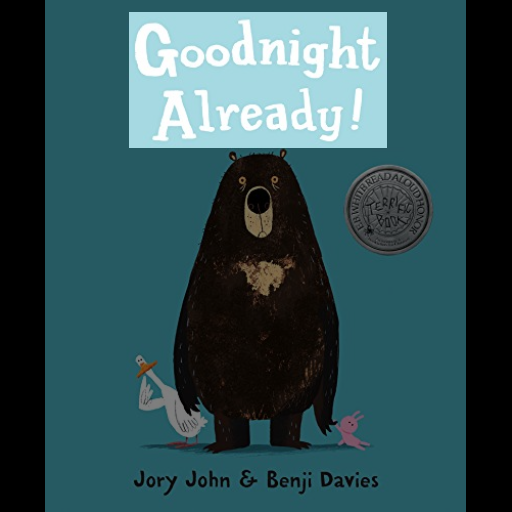

In [2]:
bg_path = './input/original.png'
mask_path = './input/mask_all.png'
bottommask_path = './input/mask_bottom.png'

im = Image.open(bg_path)
m = Image.open(mask_path)

im = np.array(im)
m = np.array(m.convert('RGB'))
dst = im*0.5 + m*0.5
dst = Image.fromarray(dst.astype(np.uint8))
dst

In [3]:
# define model
ckpt = './models/control_sd15_canny.pth'

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(ckpt, location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]


In [4]:
apply_canny = CannyDetector()

def blend(input_image, detected_map, mask, 
          prompt, a_prompt, n_prompt, num_samples, 
          image_resolution, ddim_steps, guess_mode, 
          strength, scale, seed, eta, 
          blending):
    
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape
        
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        # Normalize source images to [0, 1].
        source = torch.from_numpy((img.astype(np.float32) / 127.5) - 1.0).float().cuda()
        source = torch.stack([source for _ in range(num_samples)], dim=0)
        source = einops.rearrange(source, 'b h w c -> b c h w').clone()

        # encode original image
        x_0 = model.get_first_stage_encoding(model.encode_first_stage(source))
        
        # downsample mask
        _, _, dest_h, dest_w = x_0.shape 
        mask = cv2.resize(mask, (dest_w, dest_h), interpolation=cv2.INTER_LINEAR) / 255.0

        mask = mask[:,:,None]
        mask = torch.from_numpy(mask.copy()).float().cuda()
        mask = torch.stack([mask for _ in range(num_samples)], dim=0)
        mask = einops.rearrange(mask, 'b h w c -> b c h w').clone()
        
        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, mask=mask, x0=x_0, xext=x_0, blending=blending,
                                                     verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)

        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        results = [x_samples[i] for i in range(num_samples)]

    return results

In [5]:
from my_util import preprocess_font, render_font_in_bbox

word = 'Goodbye!'
font = 'font/DejaVuSans.ttf'
# render word in specified font and obtain its edge
img, canny, mask = preprocess_font(bg_path, bottommask_path, word, font)

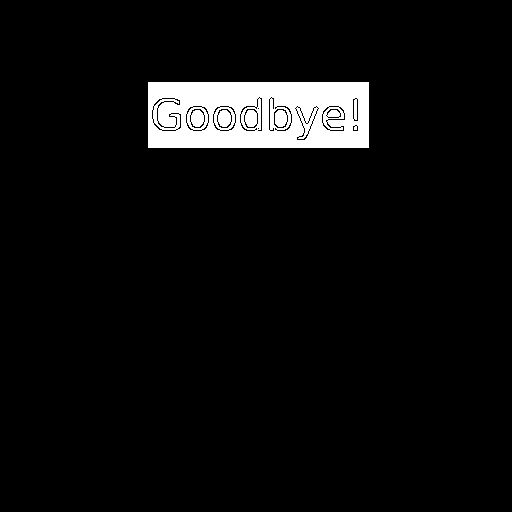

In [6]:
mask_edge = Image.fromarray((mask - canny).astype(np.uint8))
display(mask_edge)

In [7]:
## arguments for SD
a_prompt = 'best quality'#'best quality, extremely detailed'
n_prompt = 'lowres, extra letters, extra words, extra texts, extra digit, fewer digits, cropped, worst quality, low quality'

num_samples = 4
image_resolution = 512
ddim_steps = 50 
guess_mode = False 
strength = 1.0
scale = 9.0 
seed = 42 #280819145
eta = 0.0 
blending = 0.0  #blending percentage  

prompt = 'White colored texts on a book cover' 
results = blend(img, canny, mask, 
                prompt, a_prompt, n_prompt,
                num_samples, image_resolution, ddim_steps, 
                guess_mode, strength, scale, seed, eta, 
                blending)

Global seed set to 42


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


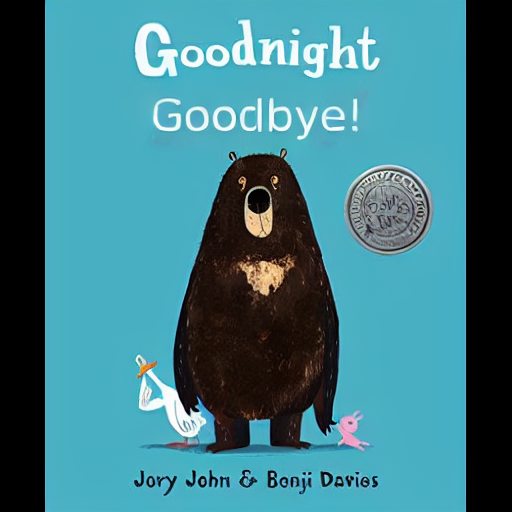

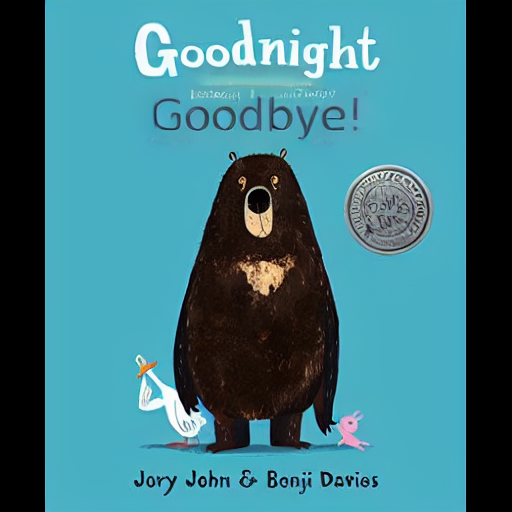

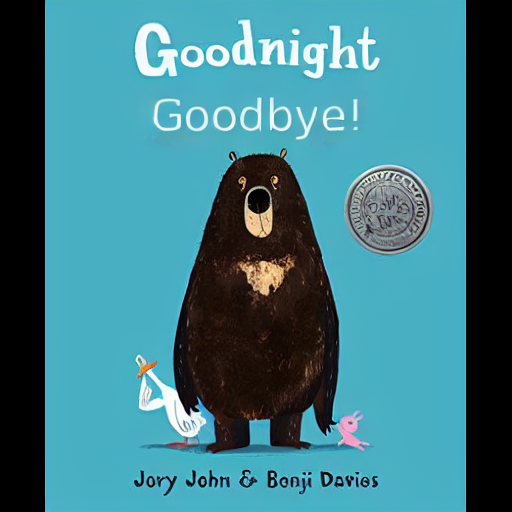

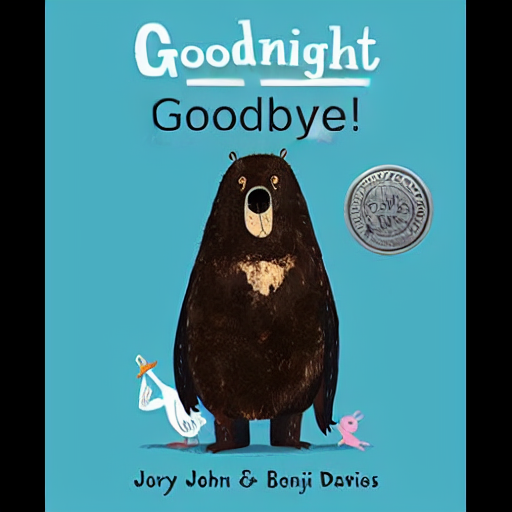

In [8]:
for res in results:
    res = Image.fromarray(res.astype(np.uint8))
    display(res)

### Edge Manipulations
Examples of edge manipulation for Reflections, 3-D and Outlines effects. More effects can be added by simple edge modifications.

#### Reflection

In [9]:
## prep edges
img = Image.open(bg_path)
img = np.array(img)

all_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
bot_mask = cv2.imread(bottommask_path, cv2.IMREAD_GRAYSCALE)

top_mask = all_mask-bot_mask

# edges of original image
cv_img = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
canny = apply_canny(cv_img, 100, 200)
canny = cv2.bitwise_and(canny, top_mask)

top_contours, _ = cv2.findContours(top_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bot_contours, _ = cv2.findContours(bot_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if top_contours and bot_contours:
    x, y, w, h = cv2.boundingRect(top_contours[0])
    x2, y2, w2, h2 = cv2.boundingRect(bot_contours[0])

    # extract edges from the top half 
    h = y2-y
    canny_region = canny[y:y+h, x:x+w]

    # flip and apply fade
    flip_canny = cv2.flip(canny_region, 0)
    gradient = np.zeros_like(flip_canny, dtype=np.uint8)
    for i in range(h):
        gradient[i, :] = int(255 * (i/h))

    # combine the original edges with the flipped edges
    new_canny = np.zeros_like(canny)
    new_canny[y:y+h, x:x+w] = canny_region
    new_canny[y+h:y+2*h, x:x+w] = flip_canny*gradient

    new_canny = cv2.bitwise_and(new_canny, all_mask)

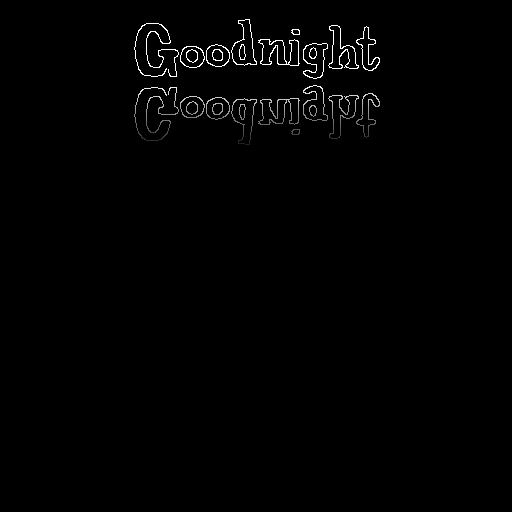

In [10]:
# show modified edges
ref_canny = Image.fromarray(new_canny.astype(np.uint8))
display(ref_canny)

In [11]:
prompt = 'Texts with reflections on a book cover'     # relections    
seed = 280819145    
ref_results = blend(img, new_canny, all_mask, 
                prompt, a_prompt, n_prompt,
                num_samples, image_resolution, ddim_steps, 
                guess_mode, strength, scale, seed, eta, 
                blending)

Global seed set to 280819145


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


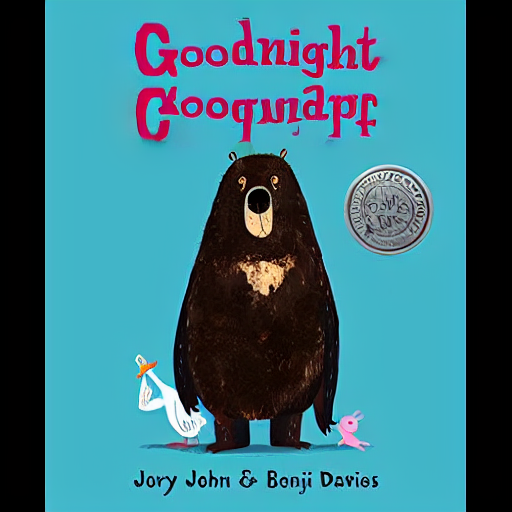

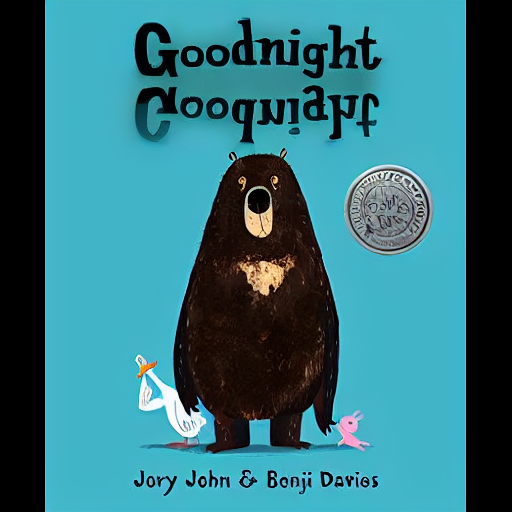

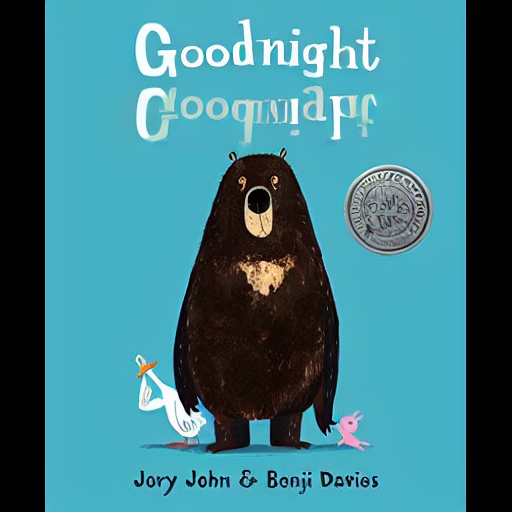

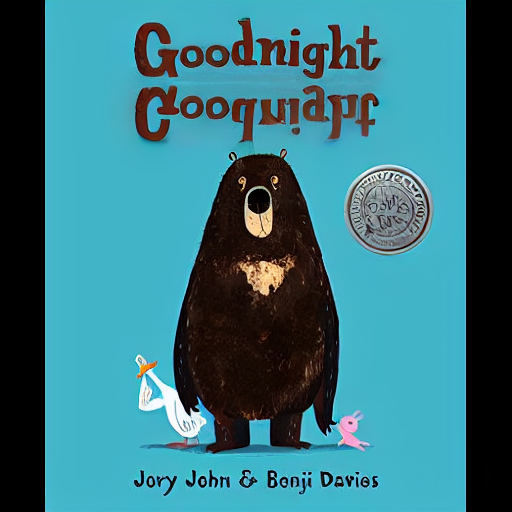

In [12]:
for res in ref_results:
    res = Image.fromarray(res.astype(np.uint8))
    display(res)

#### 3-D Effect

In [13]:
from my_util import get_bbox, render_mask

def preprocess_ownshift(ori_image_path, mask_path, shift_x, shift_y):
    '''
    prepare edge for shift (existing texts on image)
    '''
    img = Image.open(ori_image_path)
    img = np.array(img)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # m_x, m_y, m_w, m_h = get_bbox(mask, isbinary=True)
    # mask = render_mask(m_x, m_y, m_w, m_h-3)
    # mask = np.array(mask)

    cv_img = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)

    # binarize original text
    masked_img = cv2.bitwise_and(cv_img, cv_img, mask=mask)
    _, binary_image = cv2.threshold(masked_img, 127, 255, cv2.THRESH_BINARY_INV)
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(binary_image, 1, 255, cv2.THRESH_BINARY_INV)
    binary_image = cv2.bitwise_and(binary_image, mask)

    canny = apply_canny(cv_img, 100, 200)
    canny = cv2.bitwise_and(canny, mask)
    # Find contours in the binary image
    x, y, w, h = get_bbox(canny, isbinary=True)

    canny_region = canny[y:y+h, x:x+w]

    new_canny = np.zeros_like(canny)
    
    new_x = x + shift_x
    new_y = y + shift_y
    # shift canny
    new_h, new_w = new_canny[new_y:new_y+h, new_x:new_x+w].shape
    new_canny[new_y:new_y+h, new_x:new_x+w] += canny_region[:new_h, :new_w]
    # remove edges that overlap with original text
    new_canny = np.where(new_canny == binary_image, 0, new_canny).astype(np.uint8)
    new_canny += canny

    x, y, w, h = get_bbox(new_canny, isbinary=True)
    new_mask = render_mask(x, y, w, h)
    new_mask = np.array(new_mask) 
    new_mask += mask
    
    return img, new_canny, new_mask

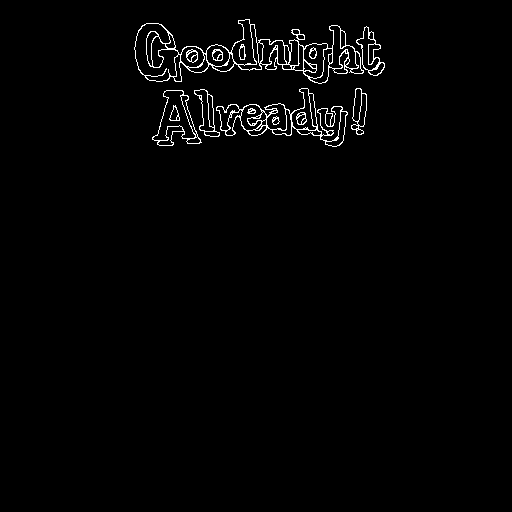

Global seed set to 280819145


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


In [14]:
img, new_canny, new_mask = preprocess_ownshift(bg_path, mask_path, 5, 5)
# show modified edges
thick_canny = Image.fromarray(new_canny.astype(np.uint8))
display(thick_canny)

prompt = '3-D texts on a book cover'     
seed = 280819145    
thick_results = blend(img, new_canny, new_mask, 
                prompt, a_prompt, n_prompt,
                num_samples, image_resolution, ddim_steps, 
                guess_mode, strength, scale, seed, eta, 
                blending)

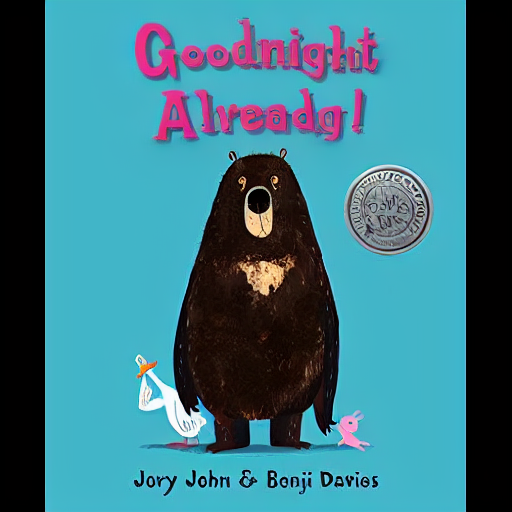

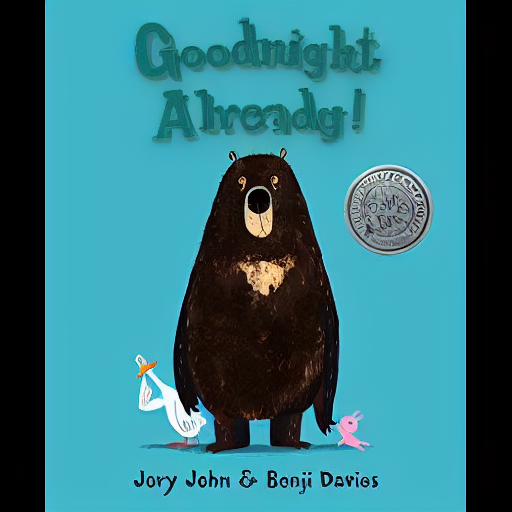

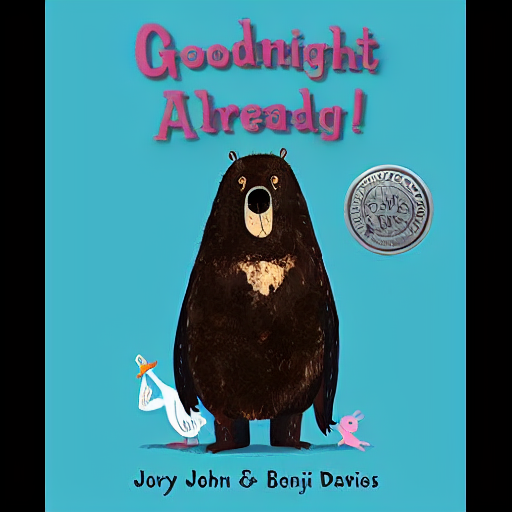

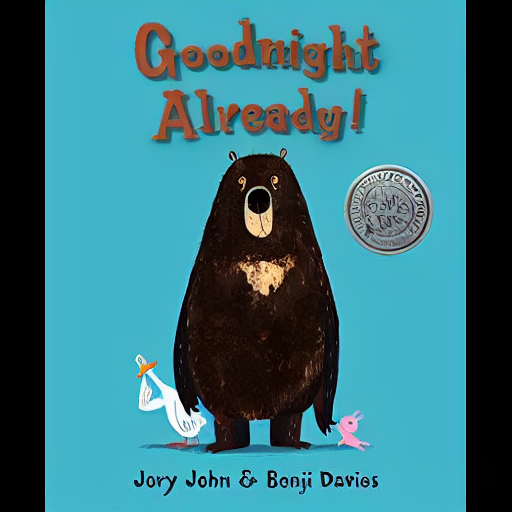

In [15]:
for res in thick_results:
    res = Image.fromarray(res.astype(np.uint8))
    display(res)

#### Outlines Effect

In [16]:
def preprocess_owndilate(ori_image_path, mask_path, k_size=10):
    '''
    prepare edge for dilate (existing texts on image)
    '''
    img = Image.open(ori_image_path)
    img = np.array(img)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    cv_img = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
    _, binary_image = cv2.threshold(cv_img, 180, 255, cv2.THRESH_BINARY)
    binary_image = cv2.bitwise_and(binary_image, mask)

    canny = apply_canny(binary_image, 100, 200)
    canny = cv2.bitwise_and(canny, mask)

    kernel = np.ones((k_size, k_size), np.uint8)
    dilated_img = cv2.dilate(binary_image, kernel, iterations=1)

    dilated_canny = apply_canny(dilated_img, 100, 200)

    new_canny = np.where(dilated_canny == binary_image, 0, dilated_canny).astype(np.uint8)
    new_canny += canny

    x, y, w, h = get_bbox(new_canny, isbinary=True)
    new_mask = render_mask(x, y, w, h)
    new_mask = np.array(new_mask)

    return img, new_canny, new_mask

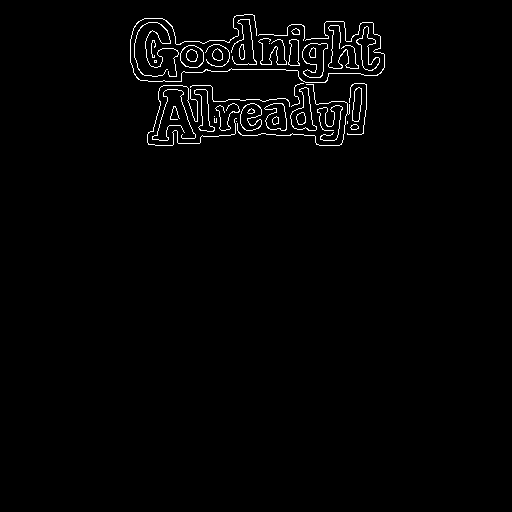

Global seed set to 42


Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


In [17]:
img, new_canny, new_mask = preprocess_owndilate(bg_path, mask_path, 10)
# show modified edges
dilate_canny = Image.fromarray(new_canny.astype(np.uint8))
display(dilate_canny)

prompt = 'Texts with glowing outlines on a book cover'    
seed = 42   
dilate_results = blend(img, new_canny, new_mask, 
                prompt, a_prompt, n_prompt,
                num_samples, image_resolution, ddim_steps, 
                guess_mode, strength, scale, seed, eta, 
                blending)

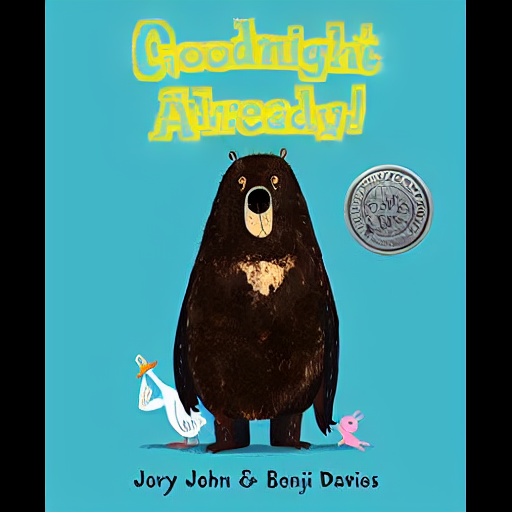

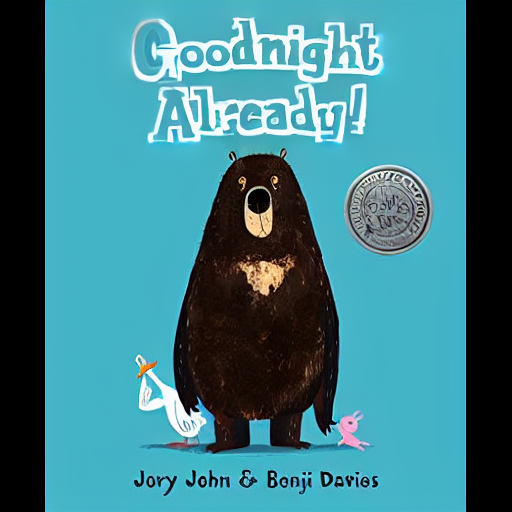

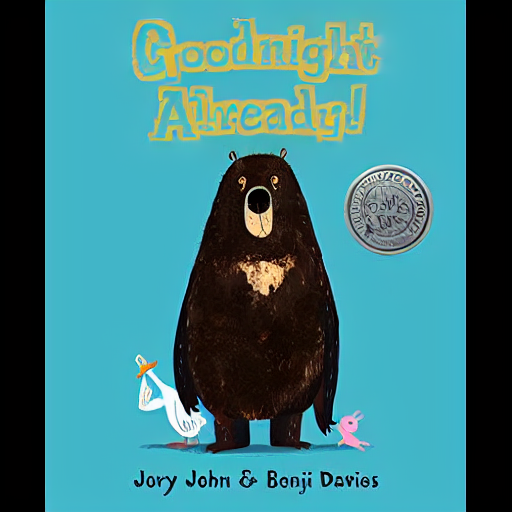

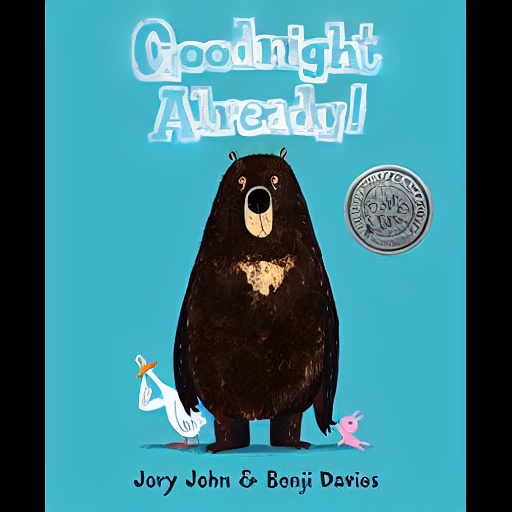

In [18]:
for res in dilate_results:
    res = Image.fromarray(res.astype(np.uint8))
    display(res)

## Refine background
Refine background by fine-tuning the U-Net decoder following the work in Blended Latent Diffusion

In [19]:
# original background as ground truth
init_image = Image.open(bg_path).convert("RGB")
init_image = np.array(init_image)
init_image = torch.from_numpy((init_image.astype(np.float32) / 127.5) - 1.0).float().unsqueeze(0).cuda()
init_image = einops.rearrange(init_image, 'b h w c -> b c h w').clone()
# mask to indicate the area to keep as it is (edited area)
init_mask_path = bottommask_path
init_mask = Image.open(init_mask_path).convert("L")
init_mask = np.array(init_mask).astype(np.float32) / 255.0
init_mask = init_mask[None, None]
init_mask[init_mask < 0.5] = 0
init_mask[init_mask >= 0.5] = 1
init_mask = torch.from_numpy(init_mask).to('cuda')

In [20]:
from reconstruct_img import ImagesDataset, reconstruct_background

r = Image.fromarray(results[0])
r.save('./output/before.png')

samples_dataset = ImagesDataset(img_list=['./output/before.png'])
optimization_steps = 75
# returns samples(numpy array) in dataset in list
reconstructed_samples = reconstruct_background(samples_dataset, init_image, init_mask, optimization_steps)

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]
Done


Reconstruction optimization: 100%|██████████| 75/75 [00:20<00:00,  3.64it/s]


#### Visualization of the diffusion model output and the refined version 
Note that the finer details (the text at the bottom, the silver seal) are more clear and refined

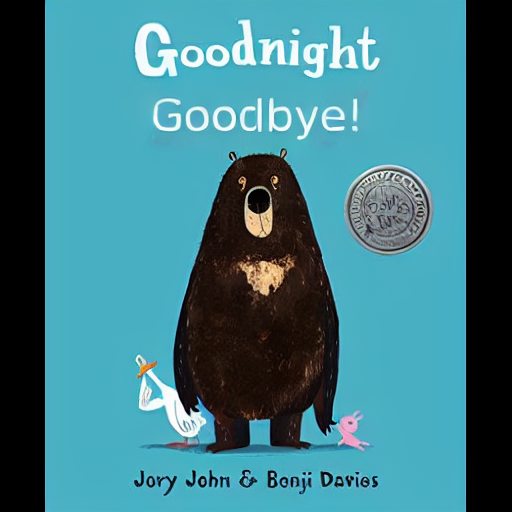

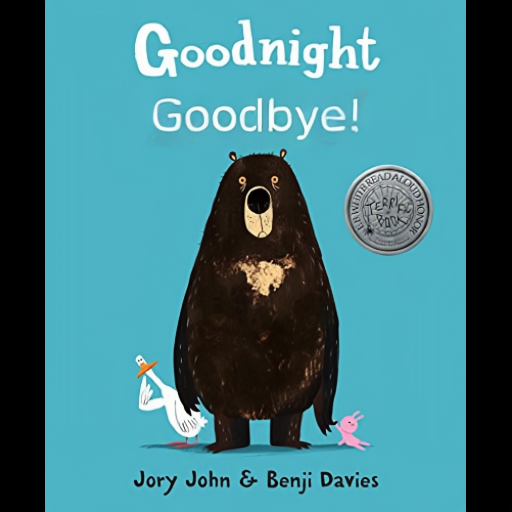

In [21]:
for i in [results[0], reconstructed_samples[0]]:
    i = Image.fromarray(i.astype(np.uint8))
    display(i)